# Etapa de pre-processamento dos dados

In [ ]:
import pandas as pd

df = pd.read_csv('trajectories_to_publish.csv');

df.head();


In [2]:
#Verificando valores nulos

print(df.isnull().sum())

#Convertendo a coluna 'time' para datetime

df['timestamp'] = pd.to_datetime(df['timestamp'])

#Verificando o tipo de dados

trip_id                   0
timestamp                 0
velocity_kmh            694
acceleration_mss    2027054
latitude                648
longitude               648
bearing                 648
dtype: int64


In [ ]:
# Preencher aceleração faltante onde a velocidade é zero
df.loc[(df['velocity_kmh'] == 0) & (df['acceleration_mss'].isnull()), 'acceleration_mss'] = 0
#Preenchendo valores faltantes de latitude e longitude quando a velocidade é zero
mask = (df['velocity_kmh'] == 0) & (df['latitude'].isnull()) & (df['longitude'].isnull())
df.loc[mask, ['latitude', 'longitude']] = df.loc[mask, ['latitude', 'longitude']].fillna(method='ffill')
#Preencher os valores faltantes do bearing com o ultimo valor conhecido quando a velocidade é zero
df.loc[(df['velocity_kmh'] == 0) & (df['bearing'].isnull()), 'bearing'] = df['bearing'].ffill()

# Verificar valores faltantes restantes
print(df.isnull().sum())

In [5]:
#Excluindo valores faltantes
df.dropna(inplace=True)

#Verificando valores faltantes
print(df.isnull().sum())

trip_id             0
timestamp           0
velocity_kmh        0
acceleration_mss    0
latitude            0
longitude           0
bearing             0
dtype: int64


In [6]:
# Função para calcular a distância entre dois pontos utilizando a fórmula de Haversine
import numpy as np
def haversine(lat1, lon1, lat2, lon2):
    # Converter de graus para radianos
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
    # Diferenças
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    # Fórmula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Raio médio da Terra em quilômetros
    return c * r

In [39]:
# Calcular a diferença de tempo em segundos
df['time_diff'] = df.groupby('trip_id')['timestamp'].diff().dt.total_seconds()
df['time_diff'] = df['time_diff'].fillna(0)

# Calcular a distância entre pontos consecutivos
df['lat_shift'] = df.groupby('trip_id')['latitude'].shift()
df['lon_shift'] = df.groupby('trip_id')['longitude'].shift()

df['segment_distance'] = haversine(
    df['latitude'], df['longitude'],
    df['lat_shift'], df['lon_shift']
)

df['segment_distance'] = df['segment_distance'].fillna(0)

# Calcular a velocidade calculada (opcional, para validação)
df['calculated_speed'] = (df['segment_distance'] / (df['time_diff'] / 3600)).replace([np.inf, -np.inf], 0)

# Calcular mudanças no bearing
df['bearing_shift'] = df.groupby('trip_id')['bearing'].shift()
df['bearing_change'] = (df['bearing'] - df['bearing_shift']).fillna(0).abs()

# Criar máscaras para aceleração positiva e negativa
acc_positive_mask = df['acceleration_mss'] > 0
acc_negative_mask = df['acceleration_mss'] < 0

# Função personalizada para agregação
def agg_by_condition(group, mask, stats=['mean', 'max', 'min', 'std']):
    """Calcula estatísticas apenas para valores que atendem à condição da máscara"""
    return group[mask].agg(stats)

# Calcular métricas por viagem
trip_stats = pd.concat([
    # Métricas de velocidade
    df.groupby('trip_id')['velocity_kmh'].agg(['mean', 'max', 'min', 'std']).add_prefix('velocity_kmh_'),
    
    # Métricas de aceleração positiva (aceleração)
    df.groupby('trip_id').apply(lambda x: agg_by_condition(x['acceleration_mss'], 
                                                          x['acceleration_mss'] > 0)
                              ).add_prefix('acceleration_positive_'),
    
    # Métricas de aceleração negativa (frenagem)
    df.groupby('trip_id').apply(lambda x: agg_by_condition(x['acceleration_mss'], 
                                                          x['acceleration_mss'] < 0)
                              ).add_prefix('acceleration_negative_'),
    
    # Outras métricas
    df.groupby('trip_id').agg({
        'segment_distance': 'sum',
        'time_diff': 'sum',
        'bearing_change': 'sum',
        'calculated_speed': 'mean',
        'trip_id': 'count'
    }),
    
    # Timestamps
    df.groupby('trip_id')['timestamp'].agg(['min', 'max'])
    
], axis=1)

# Adicionar contagem de eventos de aceleração/frenagem
trip_stats['acceleration_events_count'] = df[acc_positive_mask].groupby('trip_id').size()
trip_stats['braking_events_count'] = df[acc_negative_mask].groupby('trip_id').size()

# Calcular tempo total da viagem em minutos
trip_stats['trip_duration_min'] = trip_stats['time_diff'] / 60

# Calcular velocidade média geral da viagem
trip_stats['overall_avg_speed'] = (trip_stats['segment_distance'] / (trip_stats['time_diff'] / 3600)).replace([np.inf, -np.inf], 0)

# Preencher NaN com 0 para viagens que não têm eventos de aceleração ou frenagem
trip_stats = trip_stats.fillna(0)

# Exibir as primeiras linhas e as colunas disponíveis
print("Colunas disponíveis:")
print(trip_stats.columns.tolist())
print("\nPrimeiras linhas dos dados:")
print(trip_stats.head())

C:\Users\danie\AppData\Local\Temp\ipykernel_9596\4203863138.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('trip_id').apply(lambda x: agg_by_condition(x['acceleration_mss'],
C:\Users\danie\AppData\Local\Temp\ipykernel_9596\4203863138.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('trip_id').apply(lambda x: agg_by_condition(x['acceleration_mss'],


Colunas disponíveis:
['velocity_kmh_mean', 'velocity_kmh_max', 'velocity_kmh_min', 'velocity_kmh_std', 'acceleration_positive_mean', 'acceleration_positive_max', 'acceleration_positive_min', 'acceleration_positive_std', 'acceleration_negative_mean', 'acceleration_negative_max', 'acceleration_negative_min', 'acceleration_negative_std', 'segment_distance', 'time_diff', 'bearing_change', 'calculated_speed', 'trip_id', 'min', 'max', 'acceleration_events_count', 'braking_events_count', 'trip_duration_min', 'overall_avg_speed']

Primeiras linhas dos dados:
         velocity_kmh_mean  velocity_kmh_max  velocity_kmh_min  \
trip_id                                                          
T-1              49.794948             103.0               0.0   
T-10             76.772414             112.0               0.0   
T-100            29.084164              85.0               0.0   
T-1000           97.015910             134.0               0.0   
T-10000          93.366492             122.0   

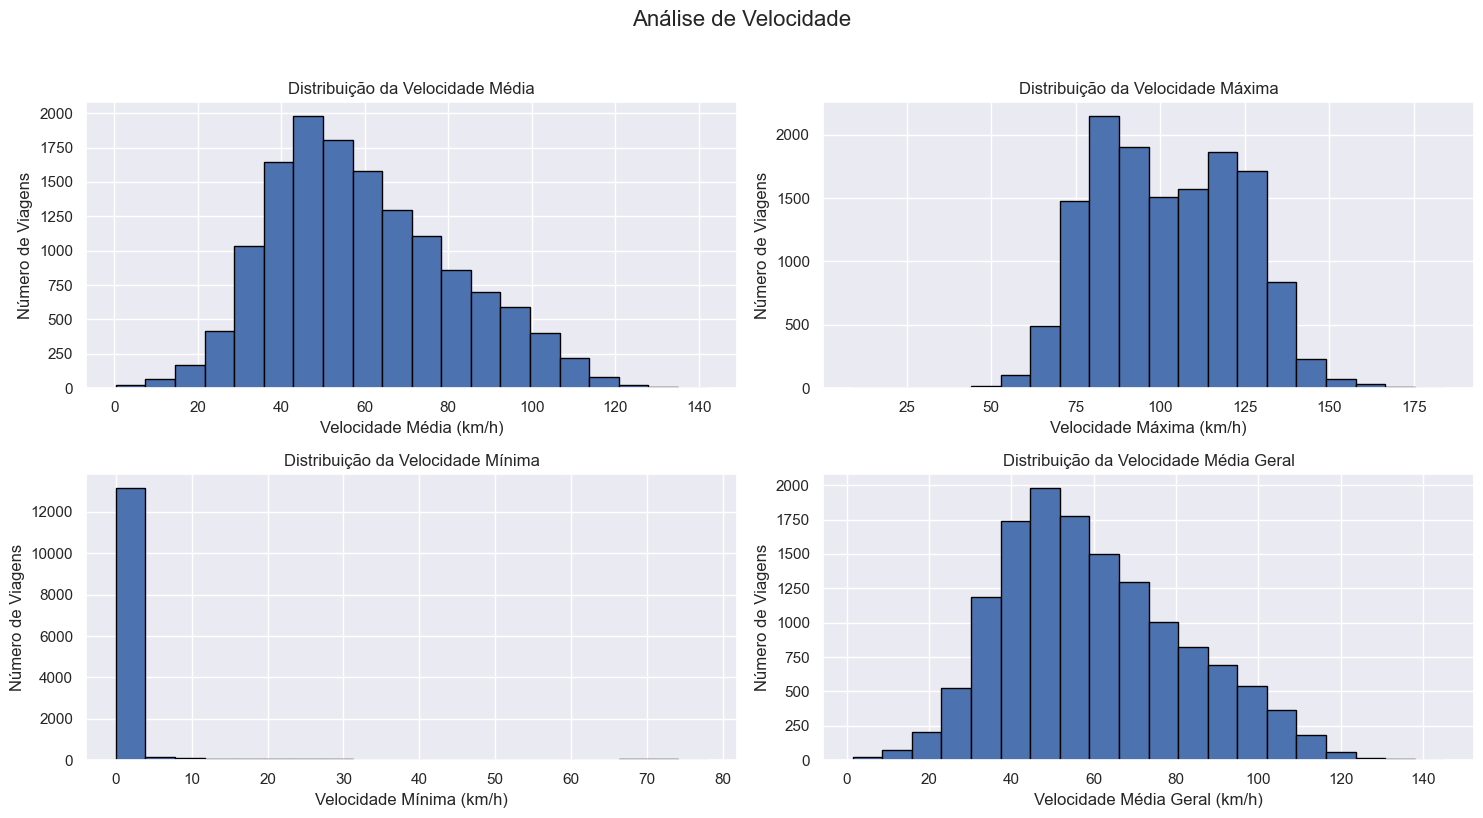

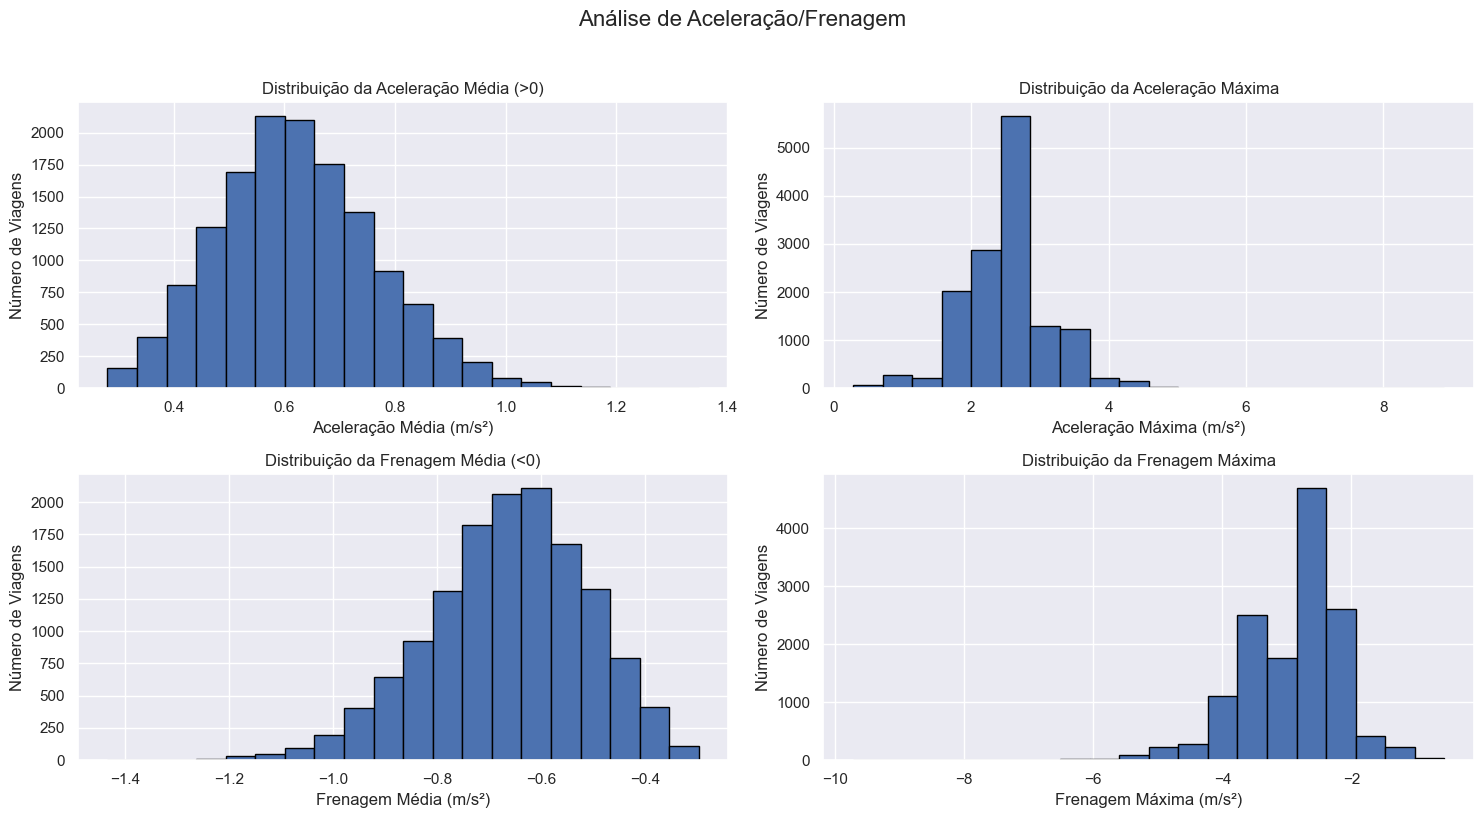

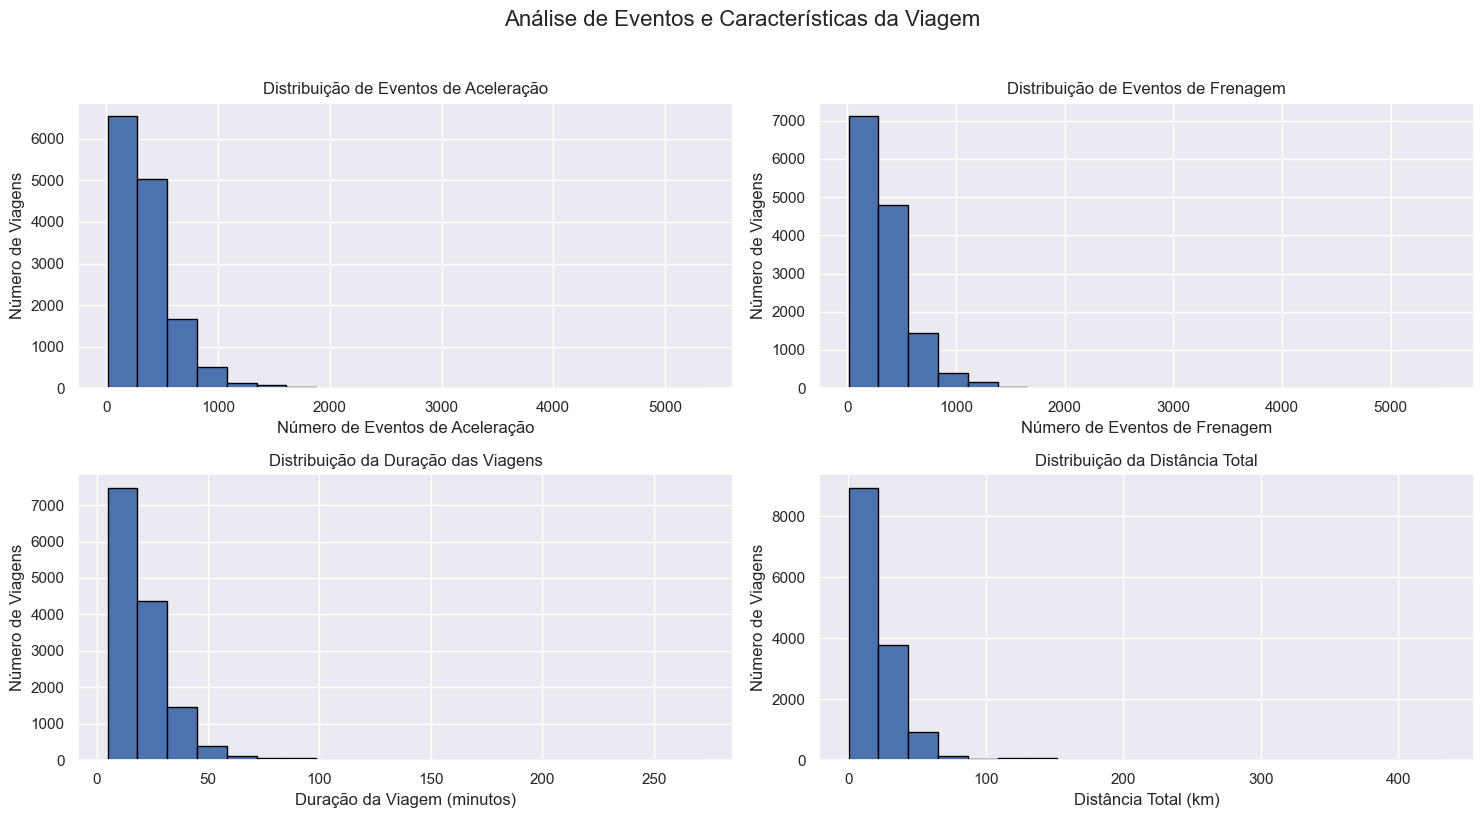

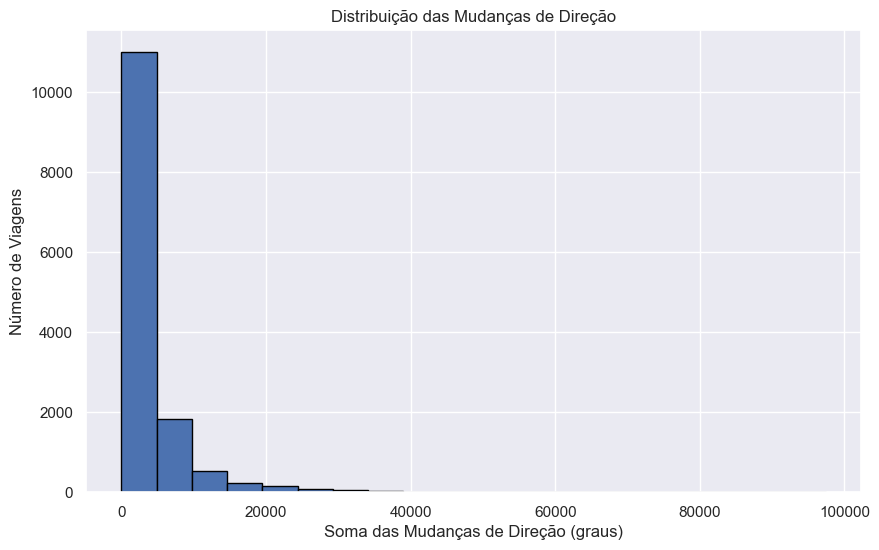

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração para melhor visualização
sns.set_theme()
plt.rcParams['figure.figsize'] = [10, 6]

# 1. Métricas de Velocidade
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
fig.suptitle('Análise de Velocidade', fontsize=16, y=1.02)

axes[0,0].hist(trip_stats['velocity_kmh_mean'], bins=20, edgecolor='black')
axes[0,0].set_xlabel('Velocidade Média (km/h)')
axes[0,0].set_ylabel('Número de Viagens')
axes[0,0].set_title('Distribuição da Velocidade Média')

axes[0,1].hist(trip_stats['velocity_kmh_max'], bins=20, edgecolor='black')
axes[0,1].set_xlabel('Velocidade Máxima (km/h)')
axes[0,1].set_ylabel('Número de Viagens')
axes[0,1].set_title('Distribuição da Velocidade Máxima')

axes[1,0].hist(trip_stats['velocity_kmh_min'], bins=20, edgecolor='black')
axes[1,0].set_xlabel('Velocidade Mínima (km/h)')
axes[1,0].set_ylabel('Número de Viagens')
axes[1,0].set_title('Distribuição da Velocidade Mínima')

axes[1,1].hist(trip_stats['overall_avg_speed'], bins=20, edgecolor='black')
axes[1,1].set_xlabel('Velocidade Média Geral (km/h)')
axes[1,1].set_ylabel('Número de Viagens')
axes[1,1].set_title('Distribuição da Velocidade Média Geral')

plt.tight_layout()
plt.show()

# 2. Métricas de Aceleração
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
fig.suptitle('Análise de Aceleração/Frenagem', fontsize=16, y=1.02)

axes[0,0].hist(trip_stats['acceleration_positive_mean'], bins=20, edgecolor='black')
axes[0,0].set_xlabel('Aceleração Média (m/s²)')
axes[0,0].set_ylabel('Número de Viagens')
axes[0,0].set_title('Distribuição da Aceleração Média (>0)')

axes[0,1].hist(trip_stats['acceleration_positive_max'], bins=20, edgecolor='black')
axes[0,1].set_xlabel('Aceleração Máxima (m/s²)')
axes[0,1].set_ylabel('Número de Viagens')
axes[0,1].set_title('Distribuição da Aceleração Máxima')

axes[1,0].hist(trip_stats['acceleration_negative_mean'], bins=20, edgecolor='black')
axes[1,0].set_xlabel('Frenagem Média (m/s²)')
axes[1,0].set_ylabel('Número de Viagens')
axes[1,0].set_title('Distribuição da Frenagem Média (<0)')

axes[1,1].hist(trip_stats['acceleration_negative_min'], bins=20, edgecolor='black')
axes[1,1].set_xlabel('Frenagem Máxima (m/s²)')
axes[1,1].set_ylabel('Número de Viagens')
axes[1,1].set_title('Distribuição da Frenagem Máxima')

plt.tight_layout()
plt.show()

# 3. Métricas de Eventos
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
fig.suptitle('Análise de Eventos e Características da Viagem', fontsize=16, y=1.02)

axes[0,0].hist(trip_stats['acceleration_events_count'], bins=20, edgecolor='black')
axes[0,0].set_xlabel('Número de Eventos de Aceleração')
axes[0,0].set_ylabel('Número de Viagens')
axes[0,0].set_title('Distribuição de Eventos de Aceleração')

axes[0,1].hist(trip_stats['braking_events_count'], bins=20, edgecolor='black')
axes[0,1].set_xlabel('Número de Eventos de Frenagem')
axes[0,1].set_ylabel('Número de Viagens')
axes[0,1].set_title('Distribuição de Eventos de Frenagem')

axes[1,0].hist(trip_stats['trip_duration_min'], bins=20, edgecolor='black')
axes[1,0].set_xlabel('Duração da Viagem (minutos)')
axes[1,0].set_ylabel('Número de Viagens')
axes[1,0].set_title('Distribuição da Duração das Viagens')

axes[1,1].hist(trip_stats['segment_distance'], bins=20, edgecolor='black')
axes[1,1].set_xlabel('Distância Total (km)')
axes[1,1].set_ylabel('Número de Viagens')
axes[1,1].set_title('Distribuição da Distância Total')

plt.tight_layout()
plt.show()

# 4. Mudanças de Direção
plt.figure(figsize=(10, 6))
plt.hist(trip_stats['bearing_change'], bins=20, edgecolor='black')
plt.xlabel('Soma das Mudanças de Direção (graus)')
plt.ylabel('Número de Viagens')
plt.title('Distribuição das Mudanças de Direção')
plt.show()

# Etapa de treinamento de modelos ML


Cluster 0 características:
velocity_kmh_mean               75.765572
velocity_kmh_max               125.374788
acceleration_positive_mean       0.556881
acceleration_positive_max        2.869695
acceleration_positive_min        0.282849
acceleration_negative_mean      -0.587142
acceleration_negative_max       -0.282849
acceleration_negative_min       -3.582555
bearing_change                9970.083663
segment_distance                57.464070
trip_duration_min               44.548144
Name: 0, dtype: float64
Número de viagens: 1766

Cluster 1 características:
velocity_kmh_mean               44.730474
velocity_kmh_max                88.902765
acceleration_positive_mean       0.680182
acceleration_positive_max        2.670547
acceleration_positive_min        0.280000
acceleration_negative_mean      -0.723124
acceleration_negative_max       -0.280000
acceleration_negative_min       -2.995117
bearing_change                2960.759447
segment_distance                12.208325
trip_duration_

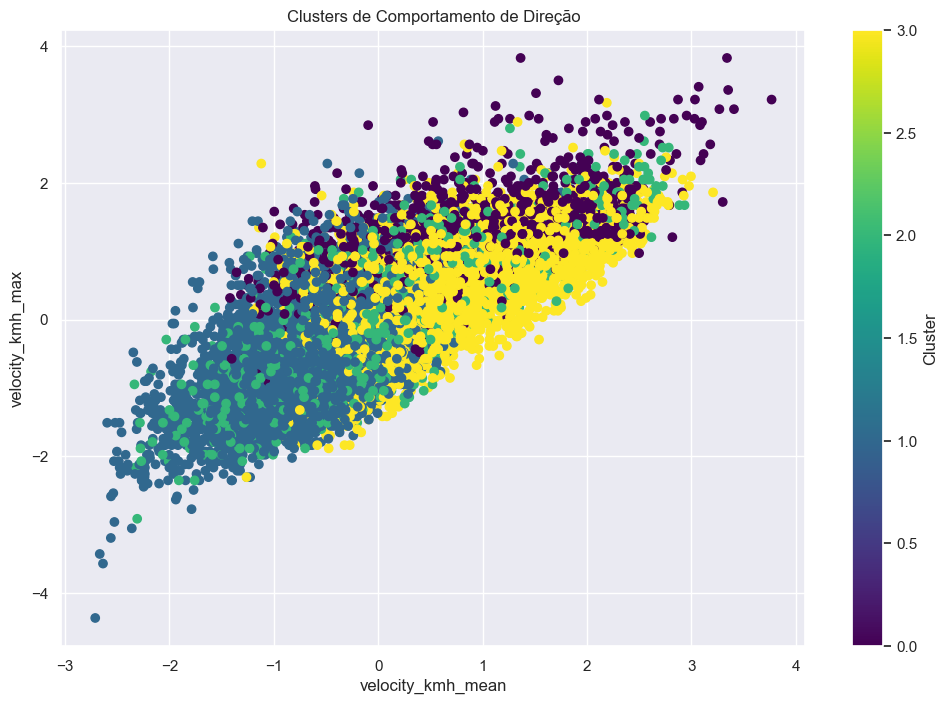

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Preparar features para clustering
features_for_clustering = [
    'velocity_kmh_mean', 'velocity_kmh_max', 'acceleration_positive_mean', 'acceleration_positive_max', 'acceleration_positive_min',
    'acceleration_negative_mean', 'acceleration_negative_max', 'acceleration_negative_min', 'bearing_change', 
    'segment_distance', 'trip_duration_min'
]

# Normalizar os dados
X = trip_stats[features_for_clustering].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar K-means
n_clusters = 4  # Você pode ajustar este número
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
trip_stats['driving_style'] = kmeans.fit_predict(X_scaled)

# Analisar os centroides
centroids = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=features_for_clustering
)

# Imprimir características de cada cluster
for i in range(n_clusters):
    print(f"\nCluster {i} características:")
    print(centroids.iloc[i])
    print(f"Número de viagens: {(trip_stats['driving_style'] == i).sum()}")

# Preparar dados para classificação
X = trip_stats[features_for_clustering]
y = trip_stats['driving_style']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Treinar Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Avaliar o modelo
train_score = rf_model.score(X_train, y_train)
test_score = rf_model.score(X_test, y_test)

print("\nRandom Forest Performance:")
print(f"Training accuracy: {train_score:.3f}")
print(f"Testing accuracy: {test_score:.3f}")

# Analisar importância das features
feature_importance = pd.DataFrame({
    'feature': features_for_clustering,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Visualizar clusters
plt.figure(figsize=(12, 8))
plt.scatter(
    X_scaled[:, 0], X_scaled[:, 1], 
    c=trip_stats['driving_style'], 
    cmap='viridis'
)
plt.xlabel(features_for_clustering[0])
plt.ylabel(features_for_clustering[1])
plt.title('Clusters de Comportamento de Direção')
plt.colorbar(label='Cluster')
plt.show()
